<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))
dfCovidtracking.set_index(['date'], inplace=True)


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/06-10-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0, usecols=[0,1,2,3,4,5,6,7,8,9,10,11],
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-09,1970596,105981,17557,941
2020-06-10,1991527,106870,20931,889
2020-06-11,2011952,107768,20425,898


In [7]:
dfCovidtracking.loc[dfCovidtracking.state=='CA'].groupby(by='date').sum()[['positive', 'death', 'positiveIncrease', 'deathIncrease']].tail()

,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-07,128812,4626,2796,67
2020-06-08,131319,4653,2507,27
2020-06-09,133489,4697,2170,44
2020-06-10,136191,4776,2702,79
2020-06-11,139281,4881,3090,105


In [8]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.index.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 2011952
Total deaths = 107768


,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,380892,2348113,0,2042.0,89995.0,581.0,0.0,424.0,0.0,68211.0,A,6/11/2020 00:00,2020-06-11T00:00:00Z,06/10 20:00,24442,89995.0,2020-06-11T00:00:00Z,0.0,0.0,0.0,380892.0,36,736,60103,2729005,2729005,60839,2729005,38,0,0fb149be1b73d602ac4593b54387e0547abe6206,0,0,0,0,0,
NJ,165816,864977,0,1512.0,18492.0,445.0,0.0,319.0,0.0,28376.0,A+,6/11/2020 13:00,2020-06-11T13:00:00Z,06/11 09:00,12443,18492.0,2020-06-11T13:00:00Z,0.0,0.0,0.0,165816.0,34,470,21389,1030793,1030793,21859,1030793,66,269,deec8938c1234dc15105e8e372460422efaef570,0,0,0,0,0,
CA,139281,2458366,0,4534.0,0.0,1325.0,0.0,0.0,0.0,0.0,B,6/11/2020 00:00,2020-06-11T00:00:00Z,06/10 20:00,4881,0.0,2020-06-11T00:00:00Z,2597647.0,0.0,0.0,139281.0,06,3090,53759,2597647,2597647,56849,2597647,105,0,9b801c6adb9eff3a4daa64cb26e99ffa24e132a2,0,0,0,0,0,
IL,131327,991724,0,2365.0,0.0,638.0,0.0,379.0,0.0,0.0,B,6/11/2020 00:00,2020-06-11T00:00:00Z,06/10 20:00,6363,0.0,2020-06-11T00:00:00Z,1122327.0,0.0,0.0,130603.0,17,766,21559,1123051,1123051,22325,1123051,90,0,cdd75cd6c5ecbdae5be115efc324a30507bbfc91,0,0,0,0,0,
MA,104667,578421,0,1260.0,10654.0,296.0,0.0,181.0,0.0,0.0,A+,6/11/2020 10:00,2020-06-11T10:00:00Z,06/11 06:00,7492,10654.0,2020-06-11T10:00:00Z,0.0,0.0,0.0,100504.0,25,511,10487,683088,683088,10998,683088,38,72,fb59d055cd7ad9f64708f27b97f6d6ce297133cc,0,0,0,0,0,


In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResultsIncrease', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [10]:
dfUSAPos[-7:]


,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
135,2020-06-05,1893167,545690,103201,28392,1100,0.940960
136,2020-06-06,1916229,540153,103947,23062,746,0.952423
137,2020-06-07,1936161,447151,104400,19932,453,0.962330
138,2020-06-08,1953039,399495,105040,16878,640,0.970718
139,2020-06-09,1970596,413010,105981,17557,941,0.979445
140,2020-06-10,1991527,419637,106870,20931,889,0.989848
141,2020-06-11,2011952,420248,107768,20425,898,1.000000


In [11]:
dfStatePos[-7:]

,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
93,2020-06-05,122901,55792,4485,3094,63,0.882396
94,2020-06-06,126016,69837,4559,3115,74,0.904761
95,2020-06-07,128812,53918,4626,2796,67,0.924835
96,2020-06-08,131319,68972,4653,2507,27,0.942835
97,2020-06-09,133489,55055,4697,2170,44,0.958415
98,2020-06-10,136191,54553,4776,2702,79,0.977815
99,2020-06-11,139281,56849,4881,3090,105,1.000000


In [12]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-07,1936161,18299517,1733,30299.0,216906.0,6493.0,8957.0,3298.0,753.0,506367.0,104400,216906.0,11568966.0,266428.0,3309198.0,1799623.0,19932,427219,20237411,20235678,447151,20235678,453,647,0,0,0,0,0
2020-06-08,1953039,18682134,1606,29969.0,217581.0,6394.0,9013.0,3240.0,762.0,518522.0,105040,217581.0,11792265.0,269302.0,3362828.0,1814279.0,16878,382617,20636779,20635173,399495,20635173,640,675,0,0,0,0,0
2020-06-09,1970596,19077587,1661,30547.0,219089.0,6450.0,9141.0,3090.0,771.0,524855.0,105981,219089.0,12021826.0,272484.0,3429689.0,1836287.0,17557,395453,21049844,21048183,413010,21048183,941,1508,0,0,0,0,0
2020-06-10,1991527,19476293,1737,30203.0,220602.0,6242.0,9225.0,3020.0,780.0,533504.0,106870,220602.0,11224921.0,275867.0,3477974.0,1852393.0,20931,398706,21469557,21467820,419637,21467820,889,1513,0,0,0,0,0
2020-06-11,2011952,19876116,1816,29064.0,221983.0,6067.0,9295.0,2886.0,792.0,538645.0,107768,221983.0,11339861.0,278760.0,3540246.0,1900910.0,20425,399823,21889884,21888068,420248,21888068,898,1381,0,0,0,0,0


In [13]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-07,128812,2233406,0,4525.0,0.0,1288.0,0.0,0.0,0.0,0.0,4626,0.0,2362218.0,0.0,0.0,128812.0,2796,51122,2362218,2362218,53918,2362218,67,0,0,0,0,0,0
2020-06-08,131319,2299871,0,4506.0,0.0,1301.0,0.0,0.0,0.0,0.0,4653,0.0,2431190.0,0.0,0.0,131319.0,2507,66465,2431190,2431190,68972,2431190,27,0,0,0,0,0,0
2020-06-09,133489,2352756,0,4583.0,0.0,1345.0,0.0,0.0,0.0,0.0,4697,0.0,2486245.0,0.0,0.0,133489.0,2170,52885,2486245,2486245,55055,2486245,44,0,0,0,0,0,0
2020-06-10,136191,2404607,0,4719.0,0.0,1326.0,0.0,0.0,0.0,0.0,4776,0.0,2540798.0,0.0,0.0,136191.0,2702,51851,2540798,2540798,54553,2540798,79,0,0,0,0,0,0
2020-06-11,139281,2458366,0,4534.0,0.0,1325.0,0.0,0.0,0.0,0.0,4881,0.0,2597647.0,0.0,0.0,139281.0,3090,53759,2597647,2597647,56849,2597647,105,0,0,0,0,0,0


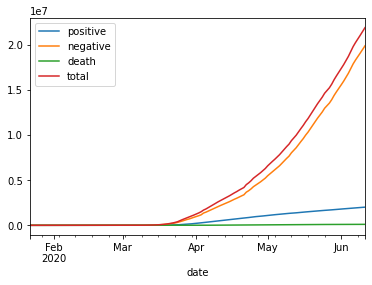

In [14]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

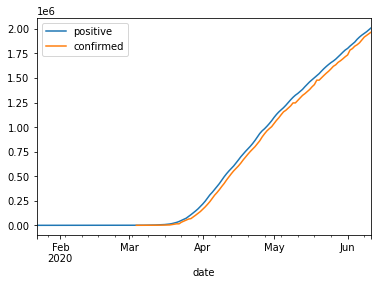

In [15]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    2000464
dead          112924
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    139715
dead           4854
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
dfJHUData.head()

,FIPS,city,state,country,last_update,lat,lon,confirmed,dead,recovered,active,key
0,45001.0,Abbeville,South Carolina,US,2020-06-11 03:33:41,34.223334,-82.461707,60,0,0,60,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-06-11 03:33:41,30.295065,-92.414197,520,29,0,491,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-06-11 03:33:41,37.767072,-75.632346,984,13,0,971,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-06-11 03:33:41,43.452658,-116.241552,854,22,0,832,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-06-11 03:33:41,41.330756,-94.471059,10,0,0,10,"Adair, Iowa, US"


In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                2000464
Brazil             772416
Russia             493023
United Kingdom     291588
India              276583
Spain              242280
Italy              235763
Peru               208823
France             192068
Germany            186522
Name: confirmed, dtype: int64

In [21]:
dfctd_state_curr.head()

,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,611,68400,0,18.0,0.0,0.0,0.0,4.0,0.0,397.0,A,6/11/2020 00:00,2020-06-11T00:00:00Z,06/10 20:00,11,0.0,2020-06-11T00:00:00Z,69011.0,0.0,0.0,0.0,02,18,1273,69011,69011,1291,69011,0,0,81be29c53674efe5eb683d80c80ed7b7a012f113,0,0,0,0,0,
AL,22845,255981,0,647.0,2165.0,0.0,650.0,0.0,380.0,13508.0,B,6/11/2020 11:00,2020-06-11T11:00:00Z,06/11 07:00,755,2165.0,2020-06-11T11:00:00Z,0.0,0.0,0.0,22474.0,01,856,4913,278826,278826,5769,278826,11,36,14deff225758b20ec967e765c4fb230342d28c70,0,0,0,0,0,
AR,10816,165849,0,187.0,925.0,0.0,0.0,45.0,150.0,7351.0,A,6/11/2020 14:50,2020-06-11T14:50:00Z,06/11 10:50,171,925.0,2020-06-11T14:50:00Z,0.0,0.0,0.0,10816.0,05,448,0,176665,176665,448,176665,6,24,0cb450ae43dfa0221fa84b39aa4ee8d2139b1de9,0,0,0,0,0,
AS,0,174,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,0.0,2020-06-01T00:00:00Z,0.0,0.0,0.0,0.0,60,0,0,174,174,0,174,0,0,cc327a5ce5cff197c218a900d7b5735a2b22db2d,0,0,0,0,0,
AZ,31264,278318,0,1291.0,3531.0,429.0,0.0,278.0,0.0,5980.0,A+,6/11/2020 00:00,2020-06-11T00:00:00Z,06/10 20:00,1127,3531.0,2020-06-11T00:00:00Z,309273.0,0.0,0.0,30955.0,04,1412,8483,309582,309582,9895,309582,32,55,108e8ab8689090d48332834df4b786e1b6dcdd33,0,0,0,0,0,


In [0]:
dfState = dfCovidtracking.reset_index()[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [24]:
dfState.loc['FL'].head(14)


,date,positive,death,total_positive,pct
state,,,,,
FL,2020-06-11,69069,2938,69069,1.000000
FL,2020-06-10,67371,2889,69069,0.975416
FL,2020-06-09,66000,2851,69069,0.955566
FL,2020-06-08,64904,2798,69069,0.939698
FL,2020-06-07,63938,2786,69069,0.925712
FL,2020-06-06,62758,2773,69069,0.908628
FL,2020-06-05,61488,2745,69069,0.890240
FL,2020-06-04,60183,2691,69069,0.871346
FL,2020-06-03,58764,2650,69069,0.850801


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

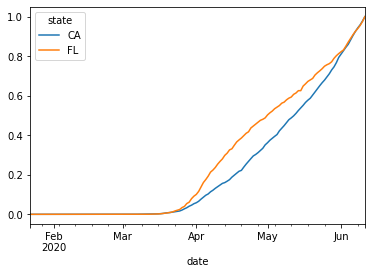

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

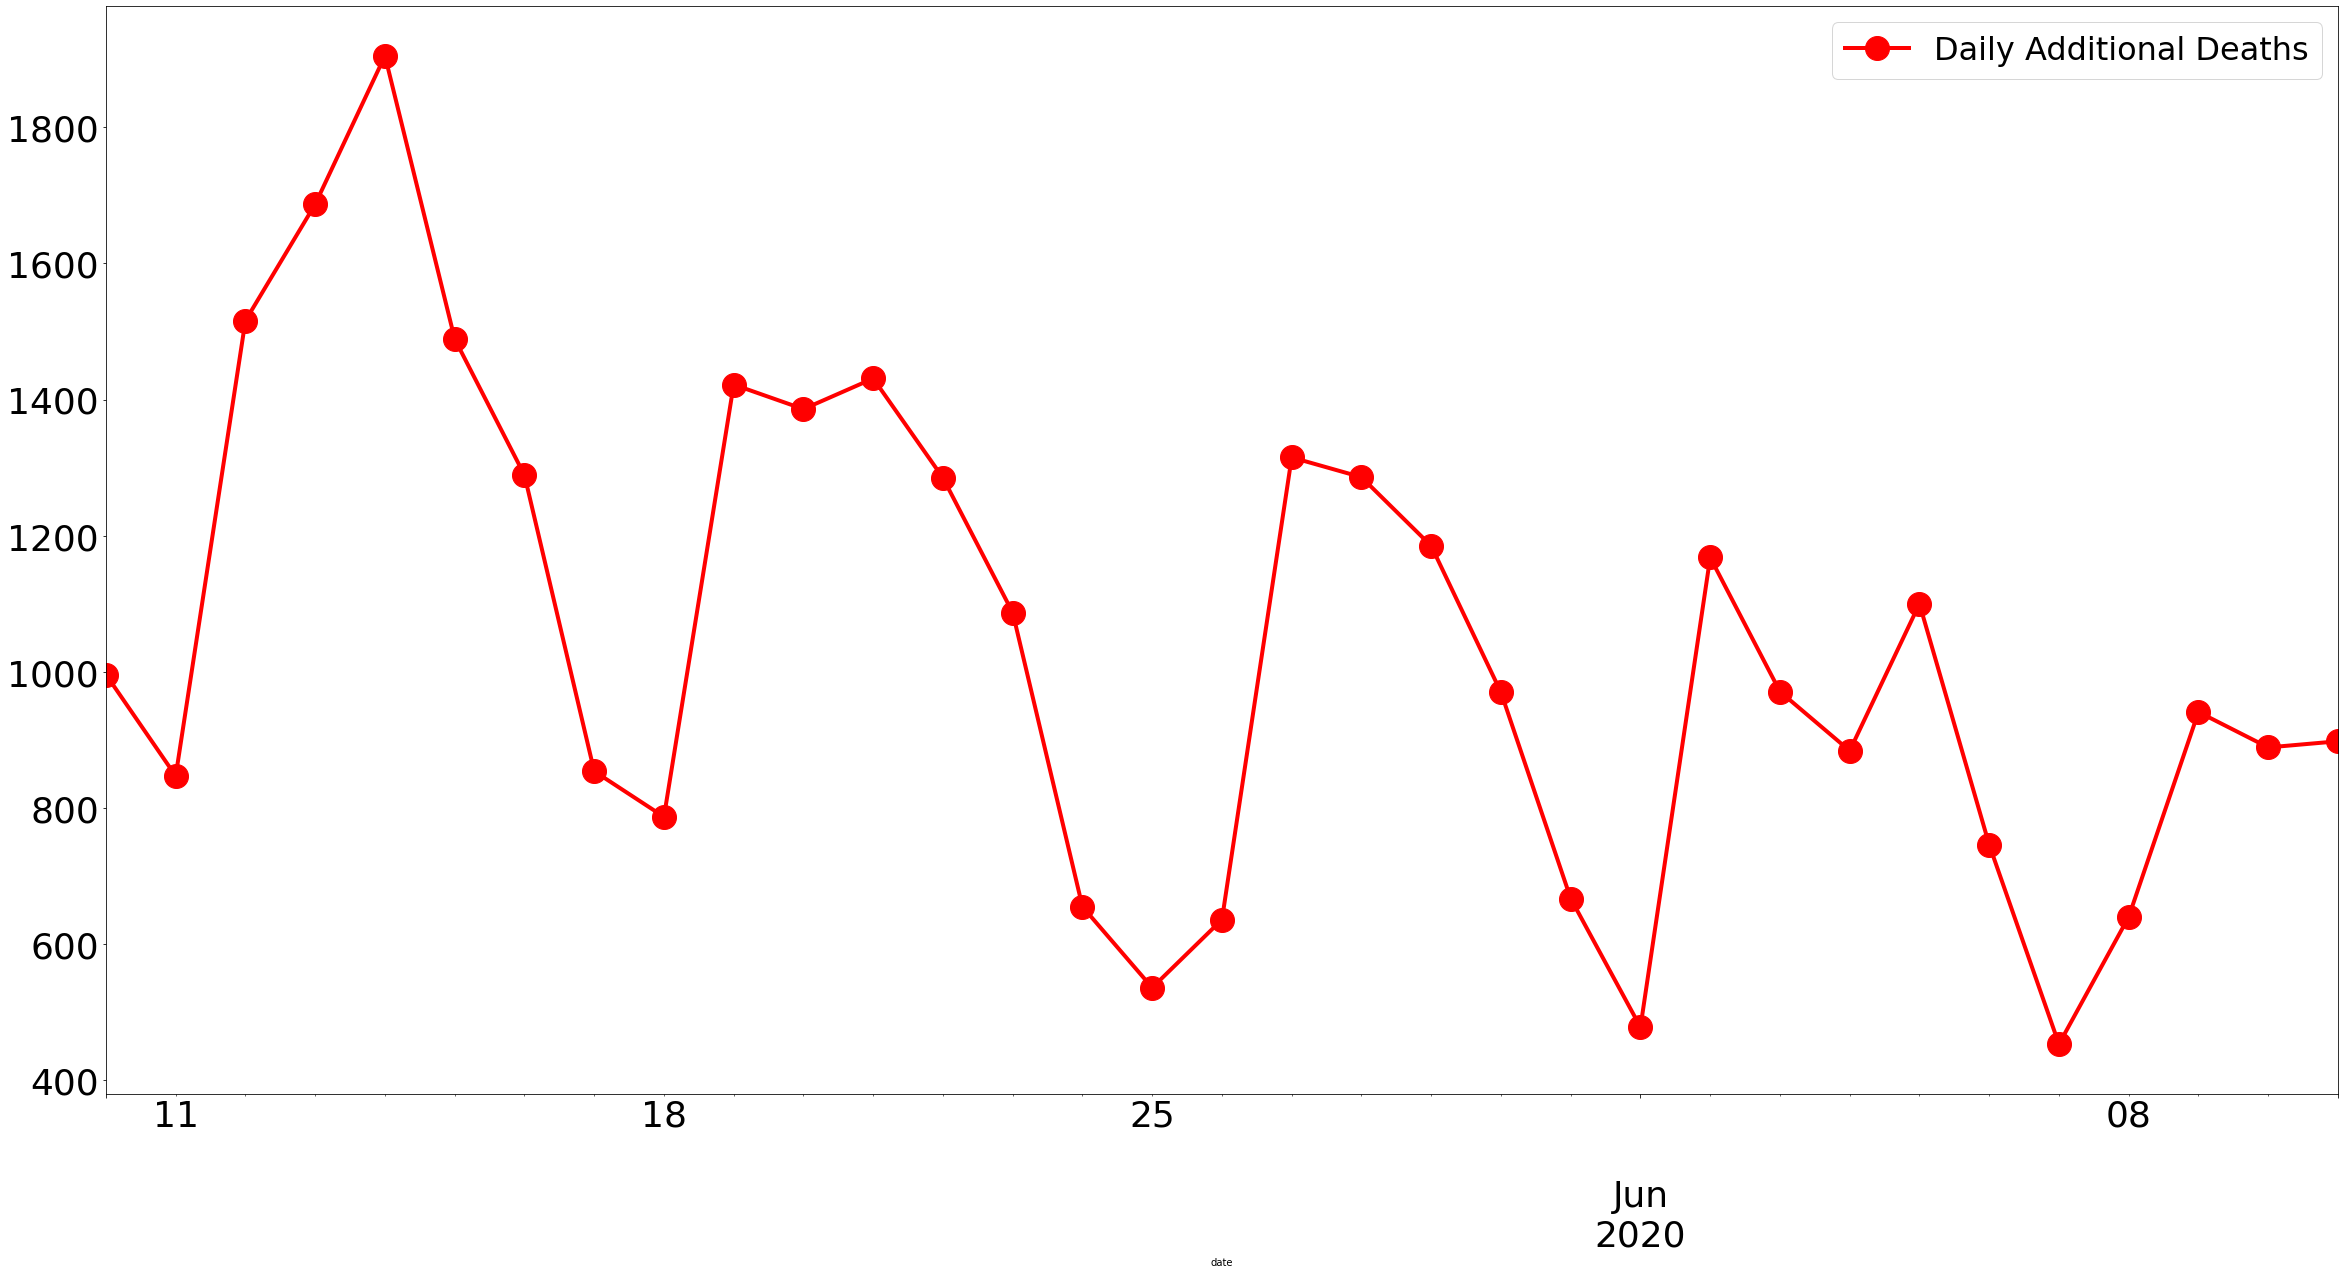

In [27]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


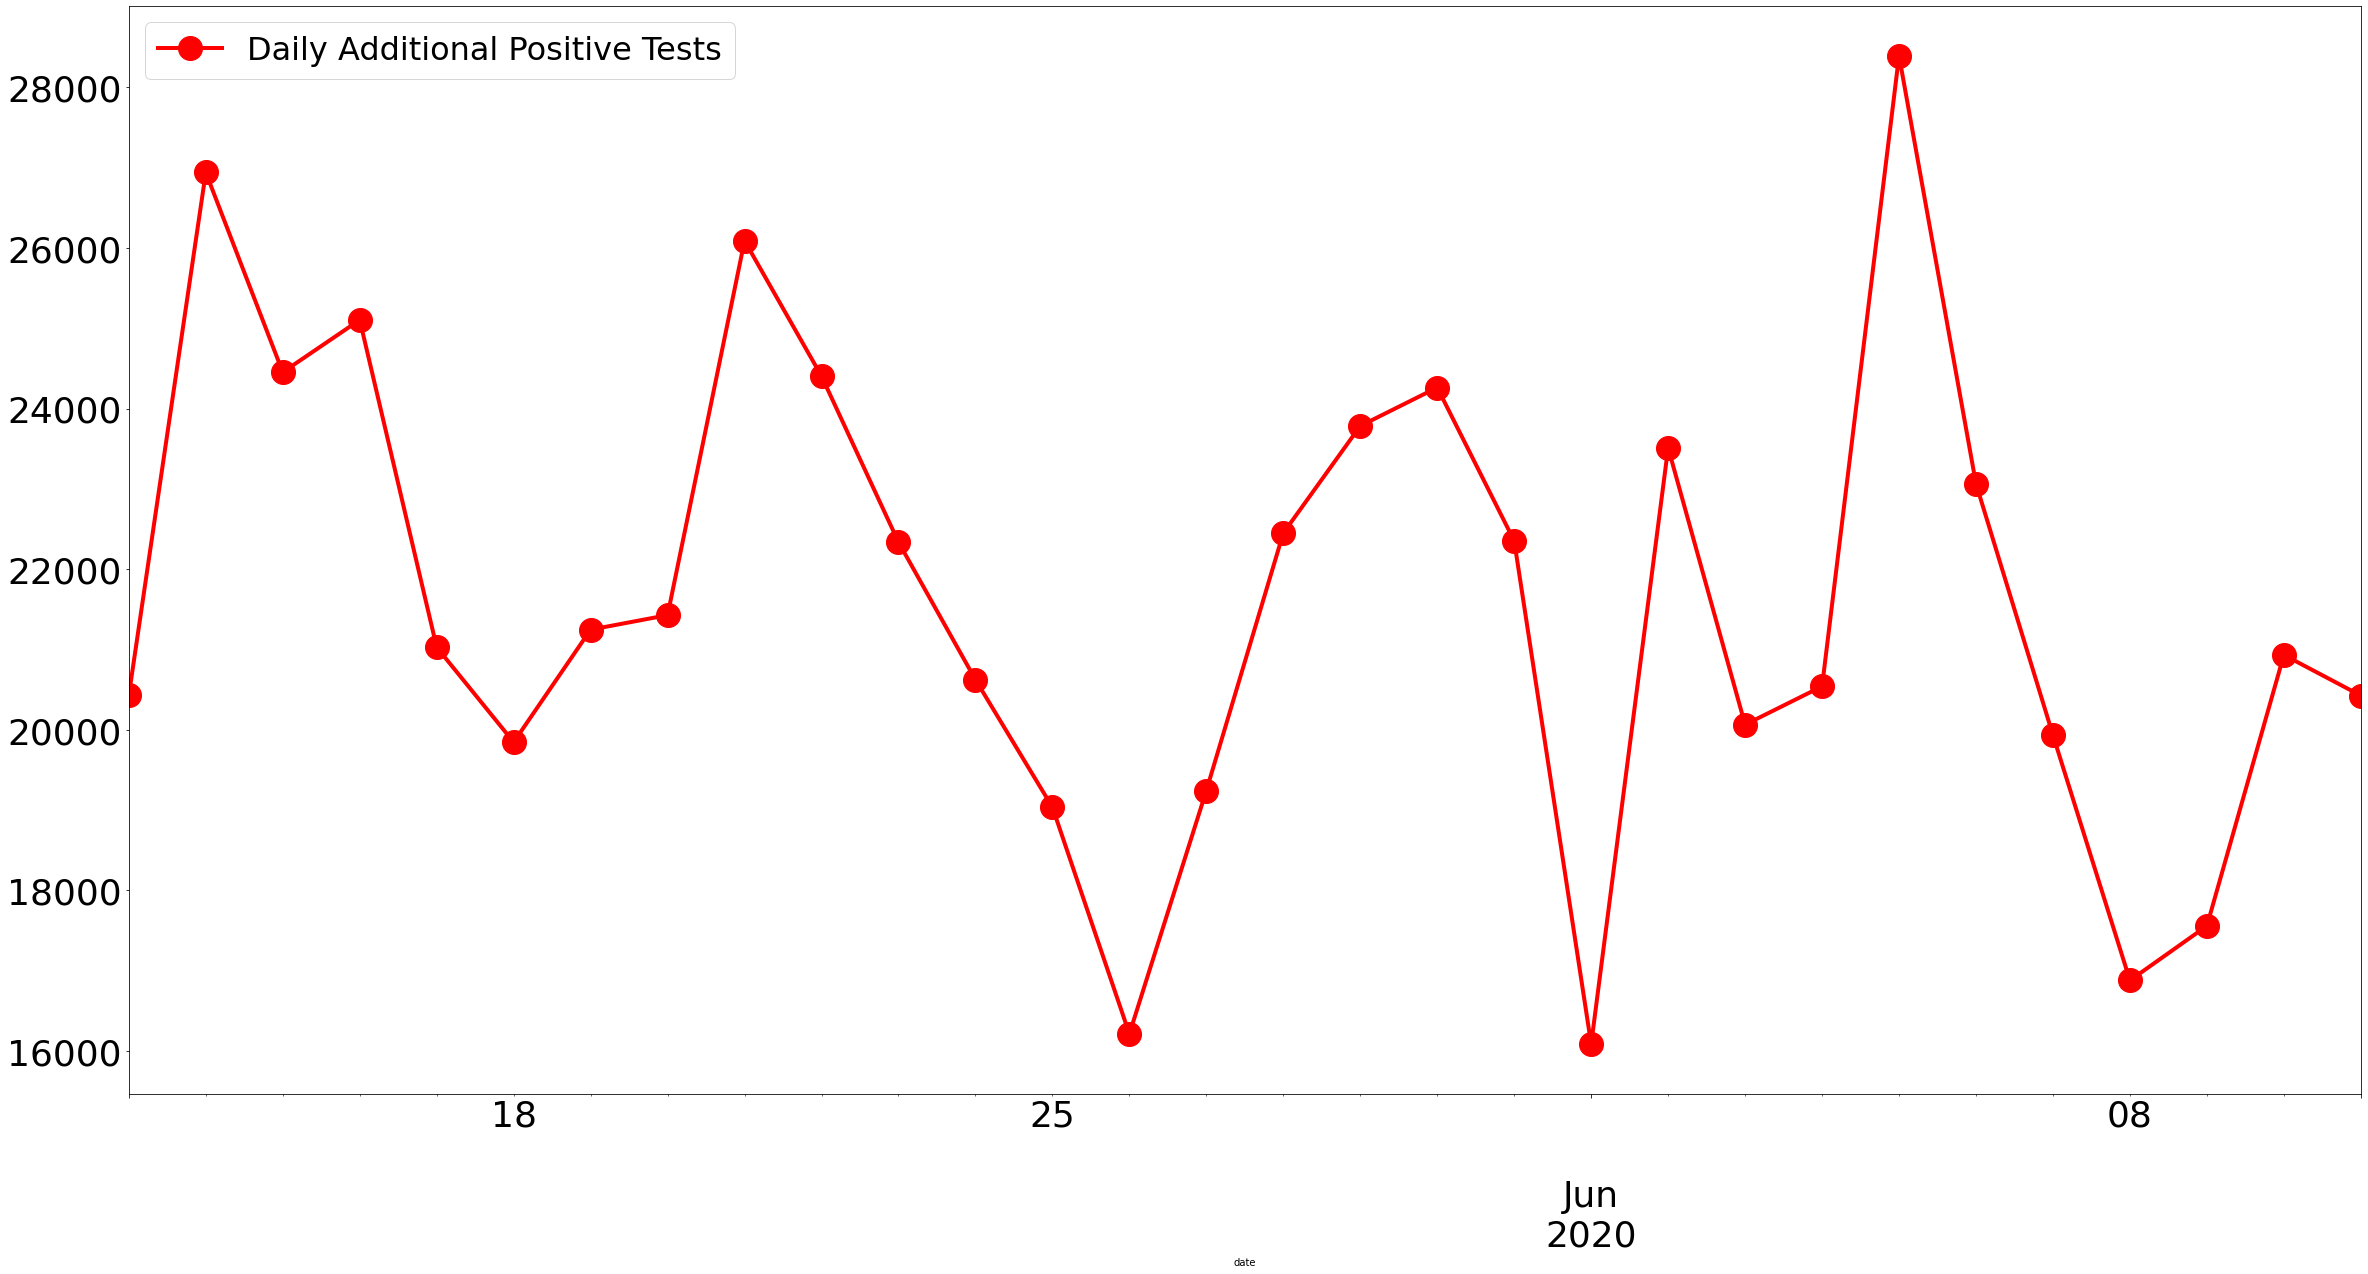

In [28]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


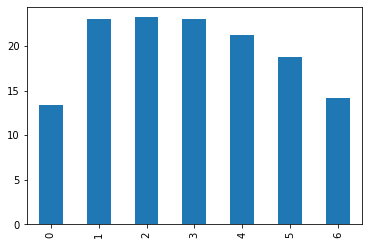

In [31]:
dfDoW.mean().deathIncrease.plot.bar()



In [32]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202018,12704,24581,1464857,191823,1656680
202019,12406,18998,1739843,170932,1910775
202020,9587,12129,2326573,156743,2483316
202021,8053,15648,2565379,155969,2721348
202022,6595,26480,2622855,147333,2770188
202023,5800,6823,3124121,151583,3275704
202024,3368,5077,1576599,75791,1652390


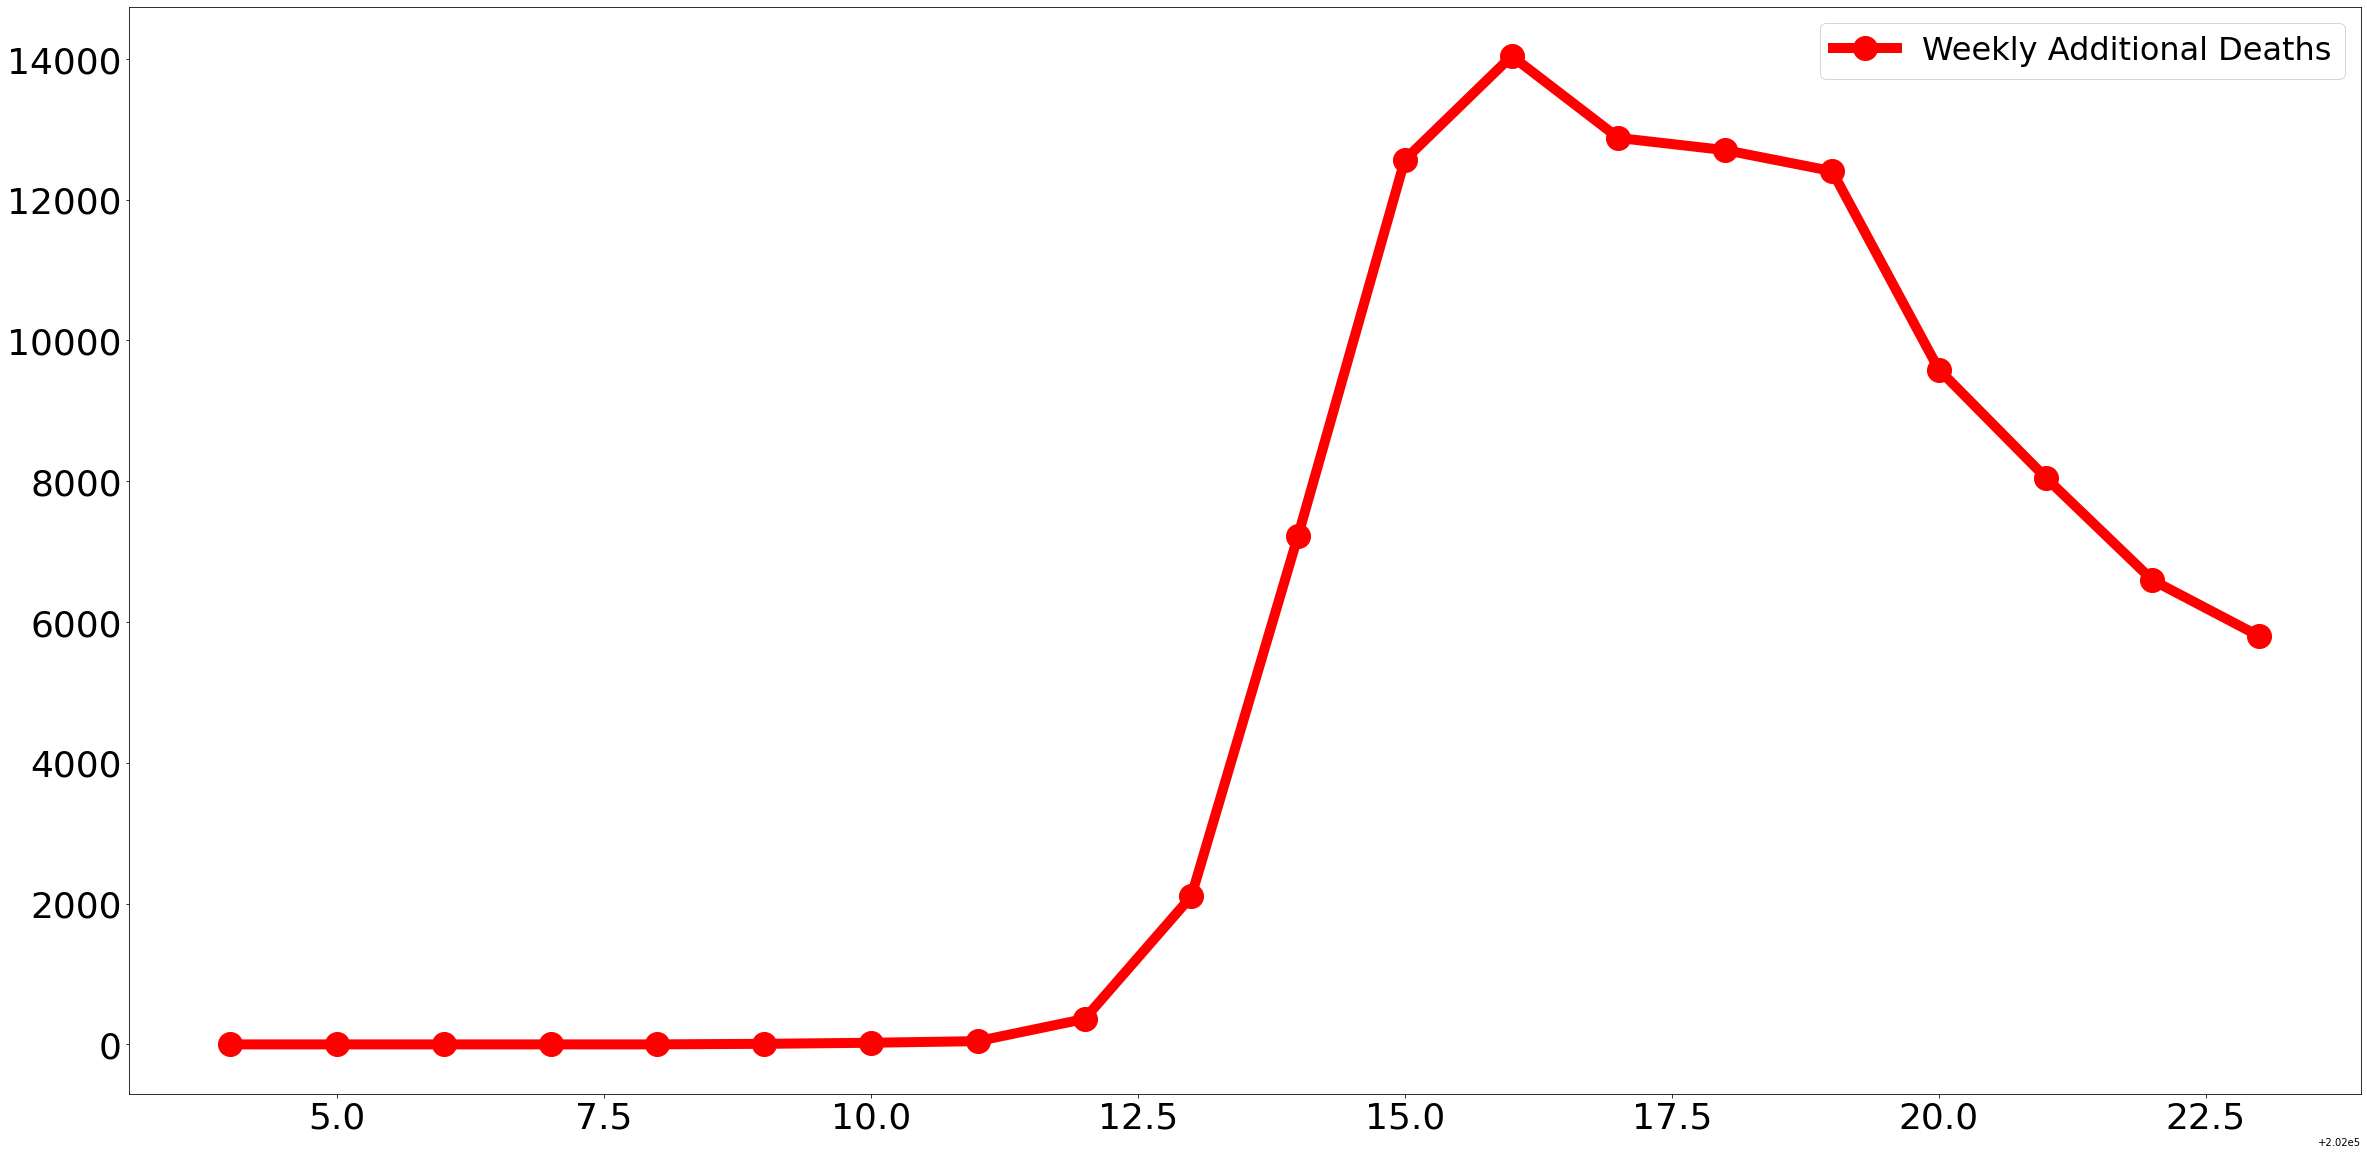

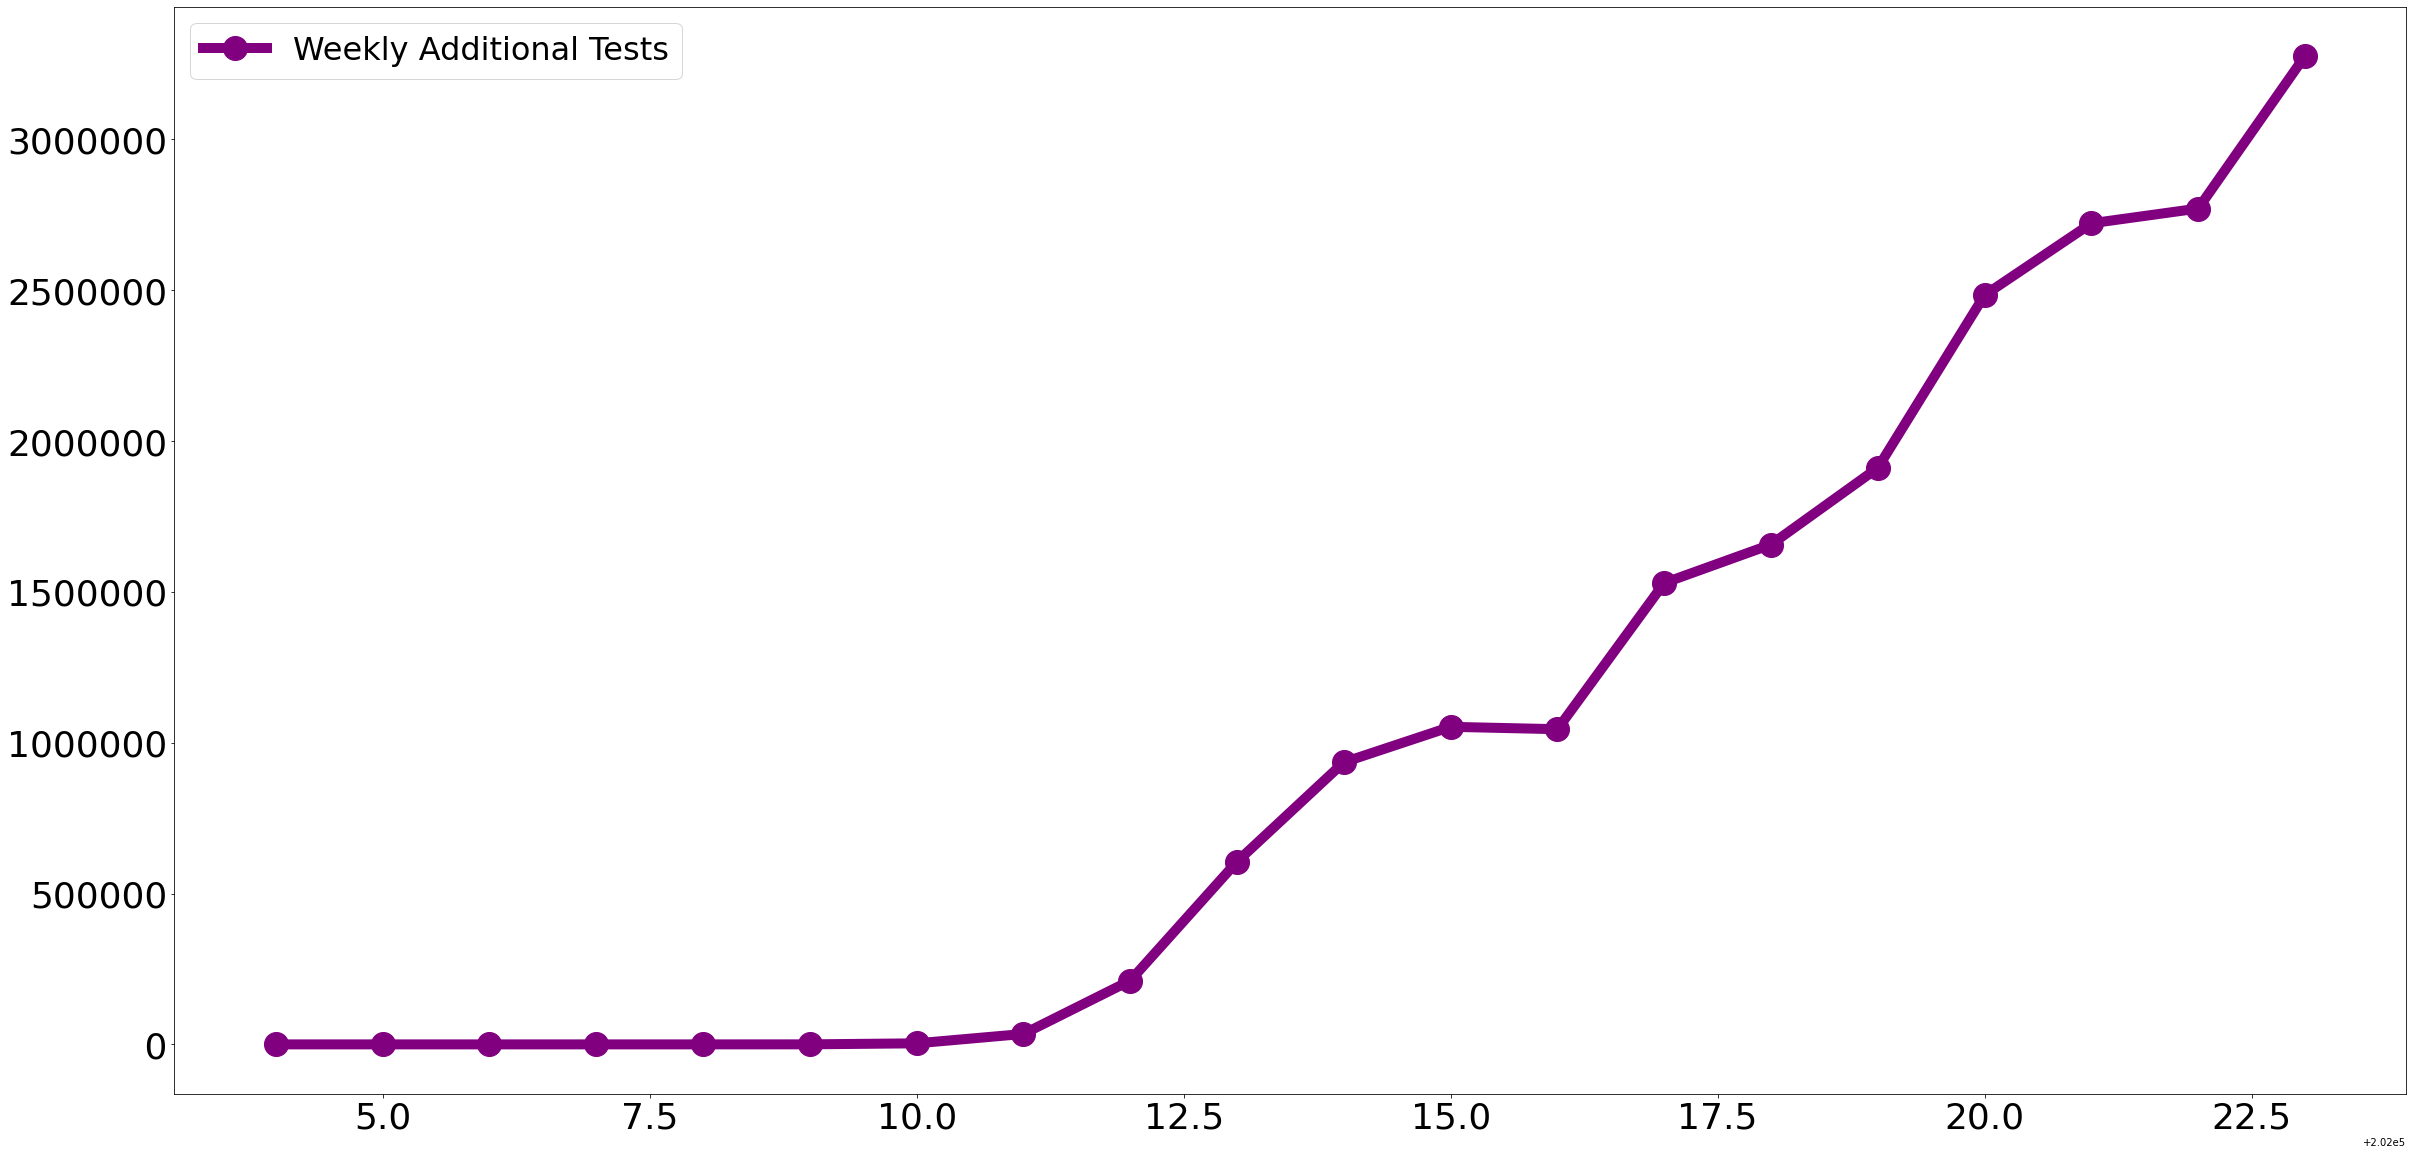

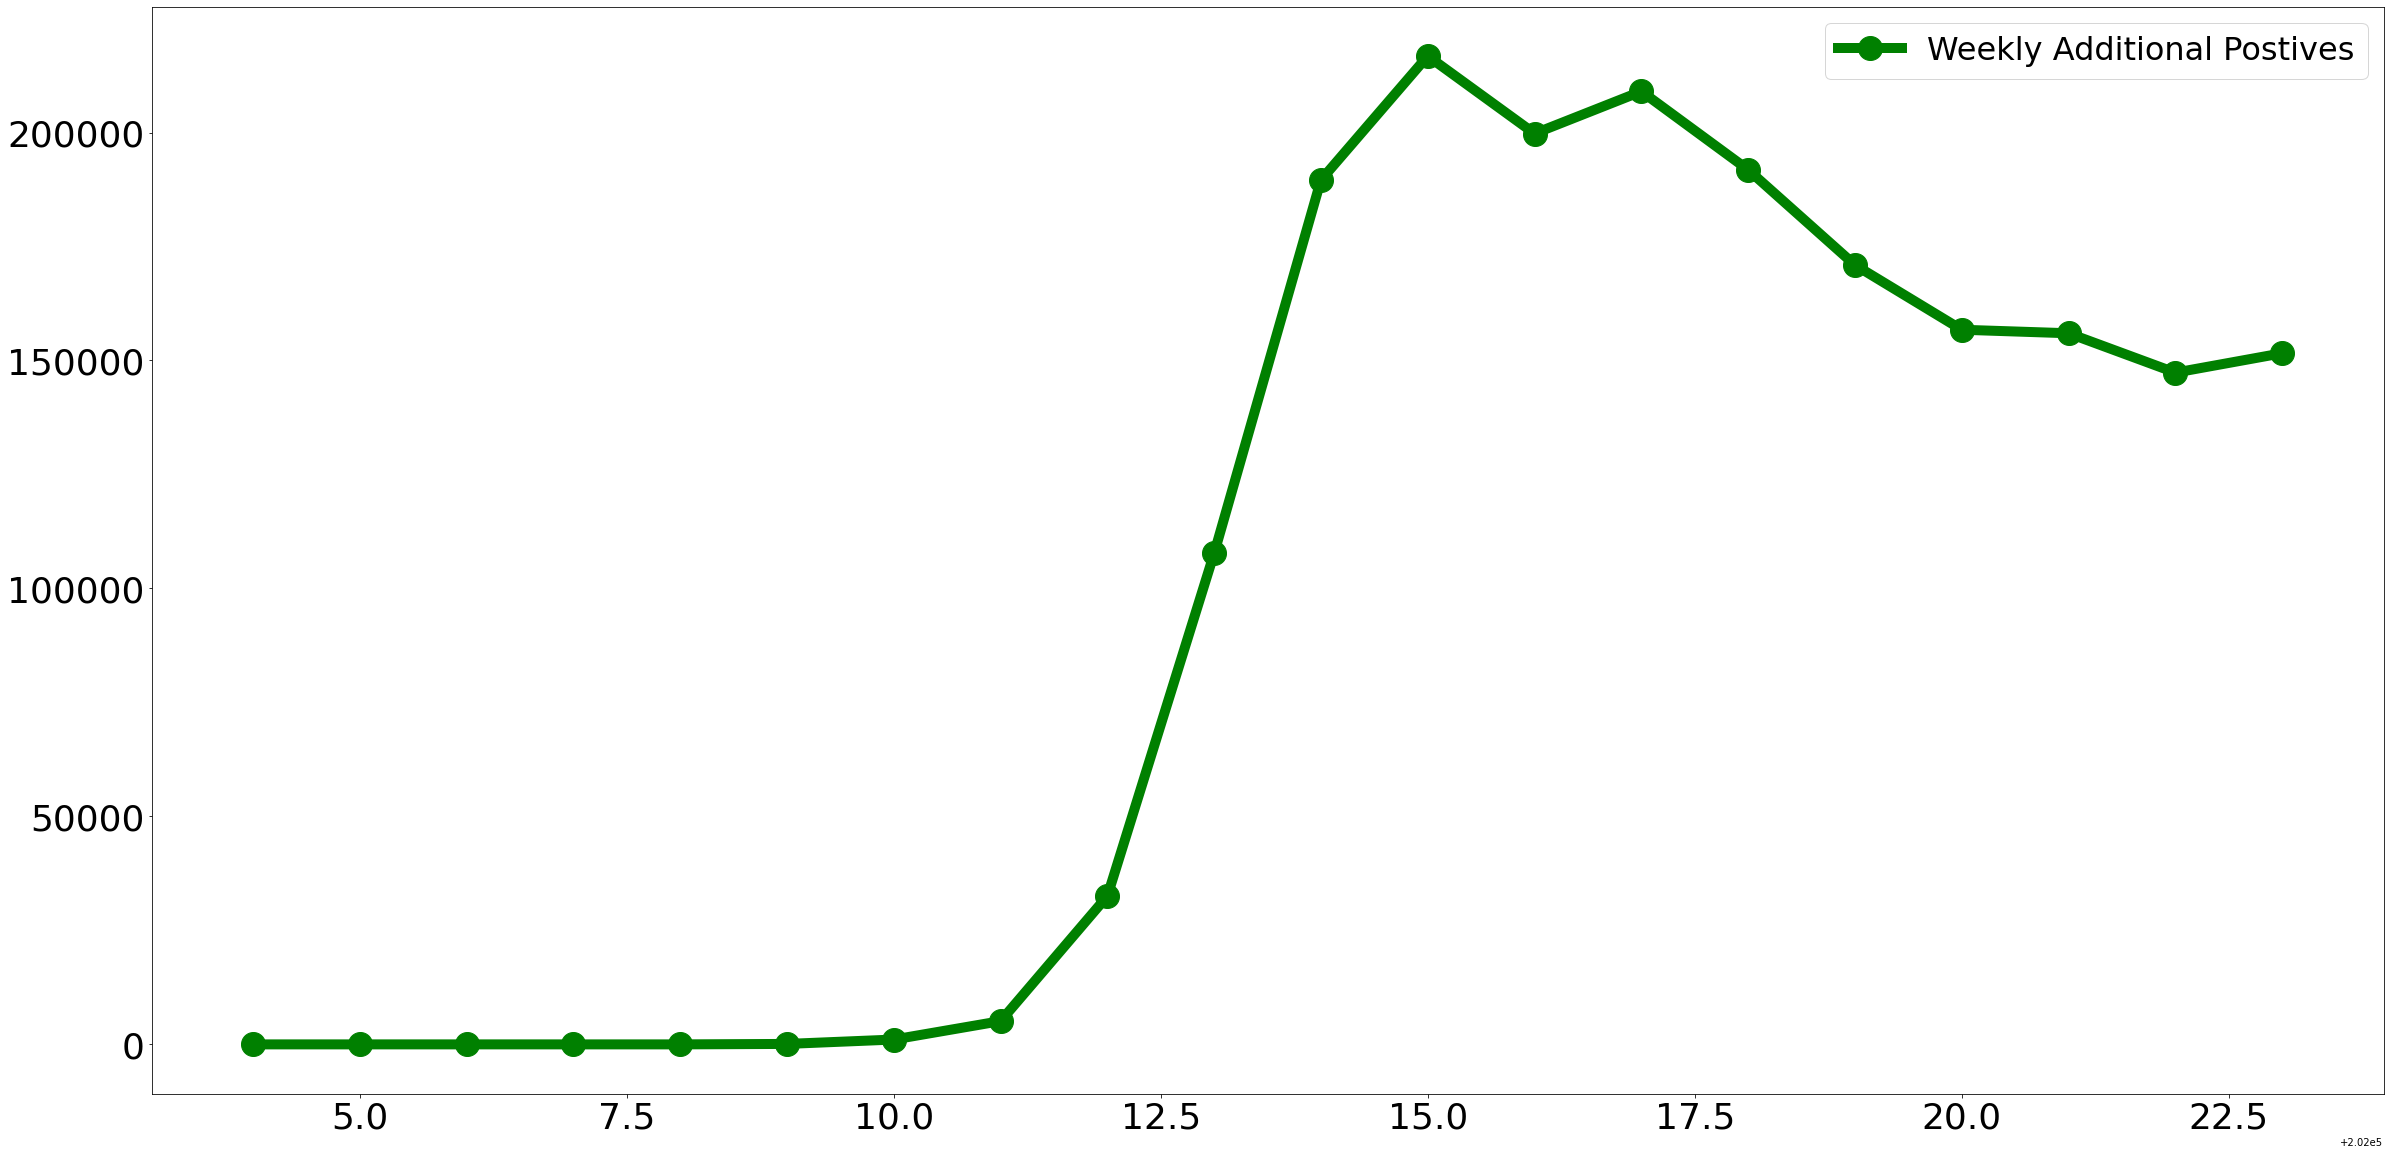

In [33]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

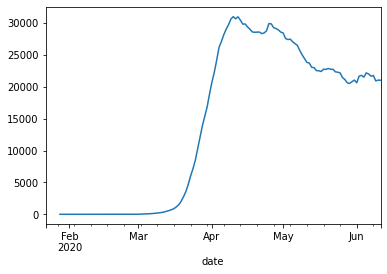

In [34]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

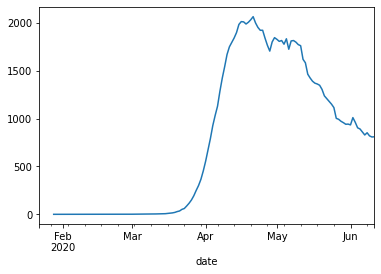

In [35]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

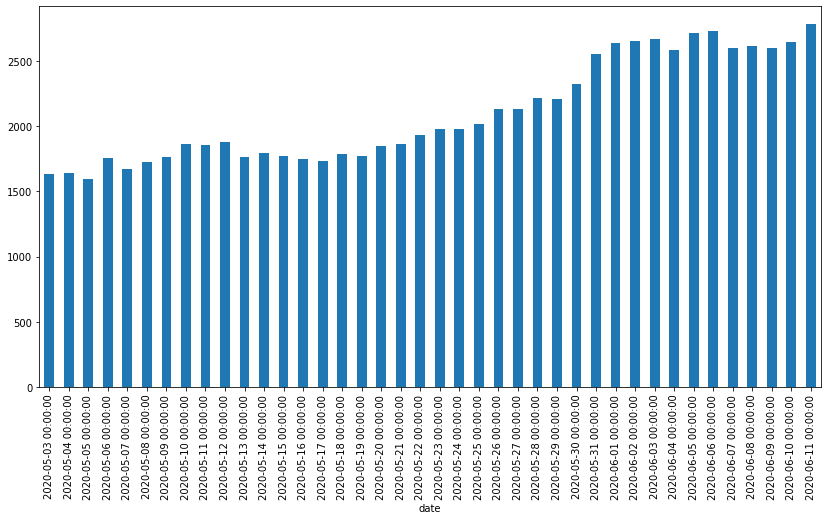

In [37]:

graph1 = dfCAAvg[-40:].positiveIncrease.plot.bar(figsize=(14,7))


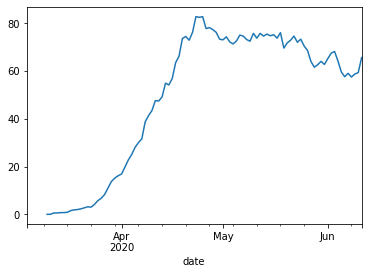

In [38]:
dfCAAvg.deathIncrease.plot.line()

In [39]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,death,total_positive,pct
1074,GA,2020-06-11,54973,2375,54973,1.000000
1075,GA,2020-06-10,53980,2329,54973,0.981937
1076,GA,2020-06-09,53249,2285,54973,0.968639
1077,GA,2020-06-08,52497,2208,54973,0.954960
1078,GA,2020-06-07,51898,2180,54973,0.944063
1079,GA,2020-06-06,51309,2174,54973,0.933349
1080,GA,2020-06-05,50621,2174,54973,0.920834
1081,GA,2020-06-04,49847,2147,54973,0.906754
1082,GA,2020-06-03,48894,2123,54973,0.889418
1083,GA,2020-06-02,48207,2102,54973,0.876921


In [40]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .85)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
388,AZ,2020-06-04,22753,996,31264,0.727770
202,AR,2020-06-04,8067,142,10816,0.745839
4297,SC,2020-06-04,13005,525,16441,0.791010
2920,NC,2020-06-04,31966,960,39481,0.809655
4693,UT,2020-06-04,10813,117,13252,0.815952
105,AL,2020-06-04,19072,653,22845,0.834844
7,AK,2020-06-04,513,10,611,0.839607
4106,PR,2020-06-04,4508,140,5352,0.842302


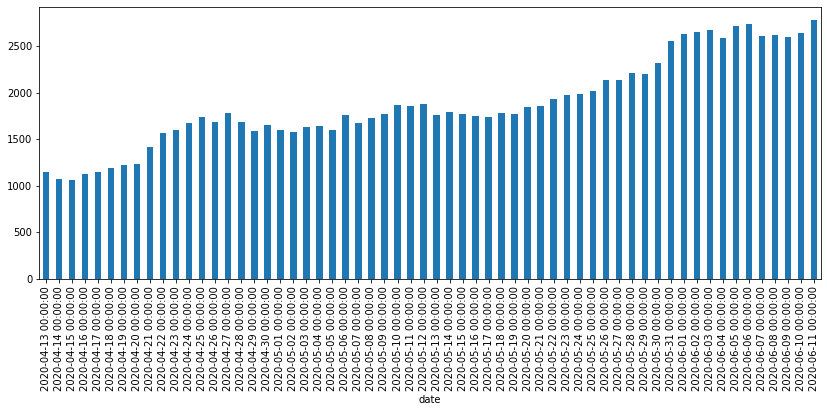

In [41]:

def showStateData(state):
  return dfCovidtracking[dfCovidtracking.state==state]\
  .sort_index()\
  .copy()



chart = showStateData('CA')\
.positiveIncrease\
.rolling(window=7)\
.mean()[-60:].plot.bar(figsize=(14,5))

In [42]:
dfTest = dfCovidtracking[dfCovidtracking.state=='CA'].sort_index().copy()
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,da5ffc320e330912eb2bda98d99788210f19d9b0,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,9c56c71986f12d235538a29d11cd0f6b74c3fb62,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,7,0,522,522,7,522,0,0,c4cb1d3cb8adf346e3e2fa0f88700667f007f331,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,9,0,531,531,9,531,0,0,ab0f7583b4a081f1c7f18137c08161c4f4a5806e,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,19,0,550,550,19,550,0,0,2f228f815b4535561a1b436cdd02c14547645345,0,0,0,0,0,


In [43]:
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,da5ffc320e330912eb2bda98d99788210f19d9b0,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,9c56c71986f12d235538a29d11cd0f6b74c3fb62,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,7,0,522,522,7,522,0,0,c4cb1d3cb8adf346e3e2fa0f88700667f007f331,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,9,0,531,531,9,531,0,0,ab0f7583b4a081f1c7f18137c08161c4f4a5806e,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,19,0,550,550,19,550,0,0,2f228f815b4535561a1b436cdd02c14547645345,0,0,0,0,0,


# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [46]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.index.max()][['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     2011952
negative    19876116
pending         1816
death         107768
total       21889884
dtype: int64
Current Infection Rate 9.191241%
Percentage of US affected: 0.645785%
Observed CFR: 5.356390%
Percentage of US tested/affected: 6.701154%
Projected affected by cir = 30,169,286
Projected killed = 1,615,985


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.index.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [54]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).\
             T.sort_values(by="state_pos_pop", ascending=False)[:50]

,state_pos_pop,state_test_pop
state,,
NY,1.957955,14.028306
NJ,1.866837,11.605167
MA,1.518563,9.910594
RI,1.497318,17.727951
DC,1.358698,8.400720
CT,1.247052,9.030072
DE,1.037828,7.602766
IL,1.036370,8.862586
MD,0.995703,6.490089


In [55]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 6.668322%


In [56]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

# OWID Data

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [58]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23183 entries, 0 to 23182
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         23119 non-null  object 
 1   continent                        22955 non-null  object 
 2   location                         23183 non-null  object 
 3   date                             23183 non-null  object 
 4   total_cases                      23183 non-null  int64  
 5   new_cases                        23183 non-null  int64  
 6   total_deaths                     23183 non-null  int64  
 7   new_deaths                       23183 non-null  int64  
 8   total_cases_per_million          22901 non-null  float64
 9   new_cases_per_million            22901 non-null  float64
 10  total_deaths_per_million         22901 non-null  float64
 11  new_deaths_per_million           22901 non-null  float64
 12  total_tests       

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [61]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    21693633.0
RUS    13875097.0
IND     5213140.0
ITA     4443821.0
DEU     4348880.0
          ...    
PRY       41702.0
BOL       39610.0
MDV       31355.0
ZWE       22805.0
CRI       22360.0
Name: total_tests, Length: 84, dtype: float64

In [62]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 65888006
Total tests done in USA : 21693633
How many more times has the world tested more than the US: 3.0


In [63]:
dfOwidLatest[isUSA].sum()

continent                            North America
location                             United States
date                                    2020-06-09
total_cases                                1961185
new_cases                                    18822
total_deaths                                111007
new_deaths                                     493
total_cases_per_million                    5924.98
new_cases_per_million                       56.864
total_deaths_per_million                   335.366
new_deaths_per_million                       1.489
total_tests                            2.16936e+07
new_tests                                   879364
total_tests_per_thousand                    65.539
new_tests_per_thousand                       2.657
new_tests_smoothed                          397889
new_tests_smoothed_per_thousand              1.202
tests_units                        tests performed
stringency_index                             72.69
population                     

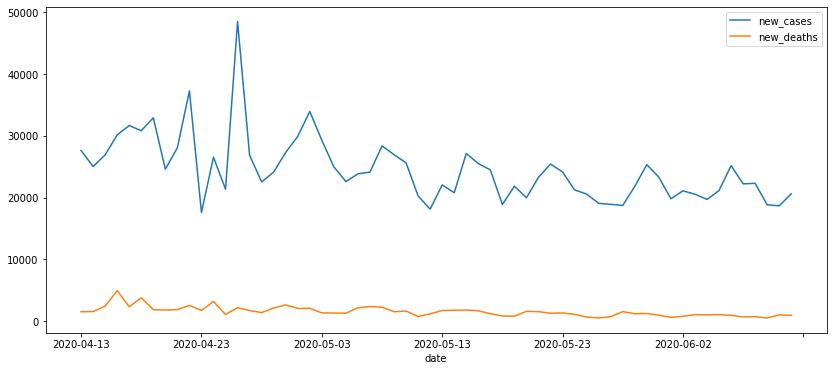

In [64]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-60:].plot.line(figsize=(14,6))

In [0]:
state = 'TX'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state]\
.rolling(window=7).mean()


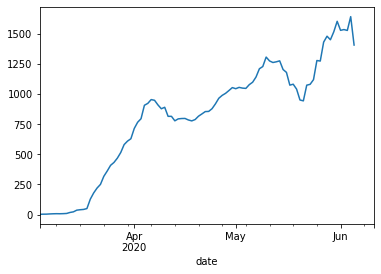

In [94]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [67]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

67371

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'][['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [69]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,346,1137,85445,6414,91859
1,543,1849,73088,8870,81958
2,415,1953,1832,9366,11198
3,395,1367,76270,8411,84681
4,336,1313,91942,8972,100914
5,203,1111,95506,6654,102160
6,137,343,105185,6284,111469


# Socrata (San Francisco) Data

In [70]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [73]:
results_df.case_disposition.unique()

array(['Death', 'Confirmed'], dtype=object)

In [0]:
res = results_df.astype({'case_count':'int16'})

In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [0]:
dfTotals = dfresConf.groupby(by='date').sum().join(dfresDead.groupby(by='date').sum(), \
        rsuffix='dead').fillna(0) \
        .rename(columns={'case_count':'positive', 'case_countdead':'dead'})

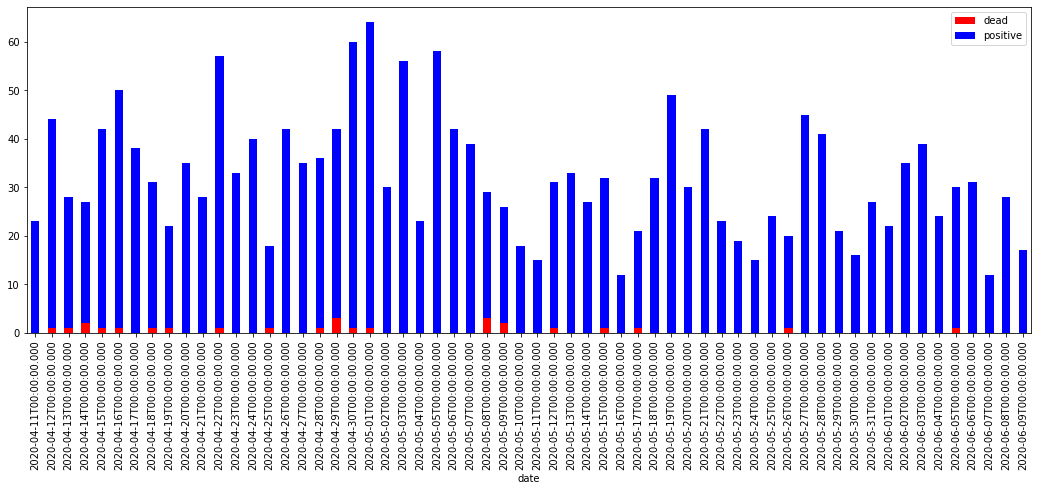

In [77]:
chart = dfTotals[['dead', 'positive']][-60:]\
.plot.bar(figsize=(18,6),stacked=True, color=['red','blue'])

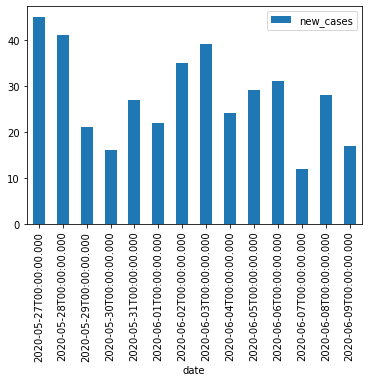

In [78]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail(14).plot.bar()

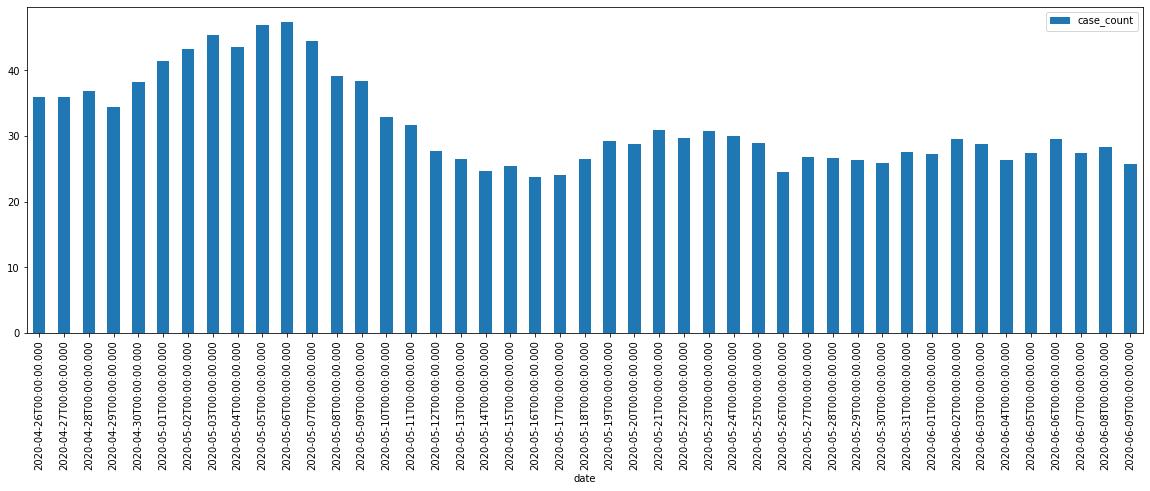

In [79]:
dfresConf.groupby('date').sum().rolling(window=7).mean()[-45:].plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [81]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-06-07,589,17.0,15962.0,52.0,405.0
2020-06-08,610,17.0,16040.0,52.0,409.0
2020-06-09,620,17.0,16548.0,52.0,427.0
2020-06-10,635,17.0,17032.0,52.0,434.0
2020-06-11,648,17.0,17367.0,49.0,463.0


In [82]:
df[['deaths','positive']].diff()

,deaths,positive
date,,
2020-03-06,NaN,NaN
2020-03-07,0.0,0.0
2020-03-08,0.0,1.0
2020-03-09,0.0,0.0
2020-03-10,NaN,0.0
...,...,...
2020-06-07,0.0,18.0
2020-06-08,0.0,21.0
2020-06-09,0.0,10.0


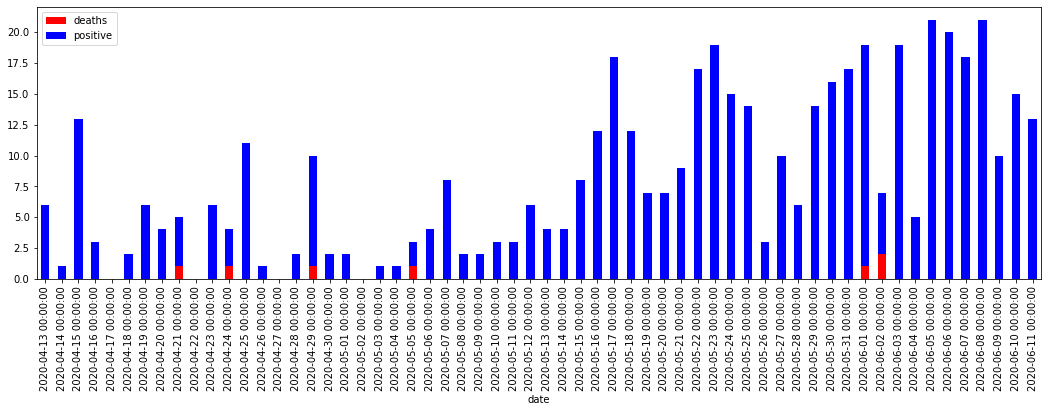

In [83]:
chart= df[['deaths','positive']].diff()[-60:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

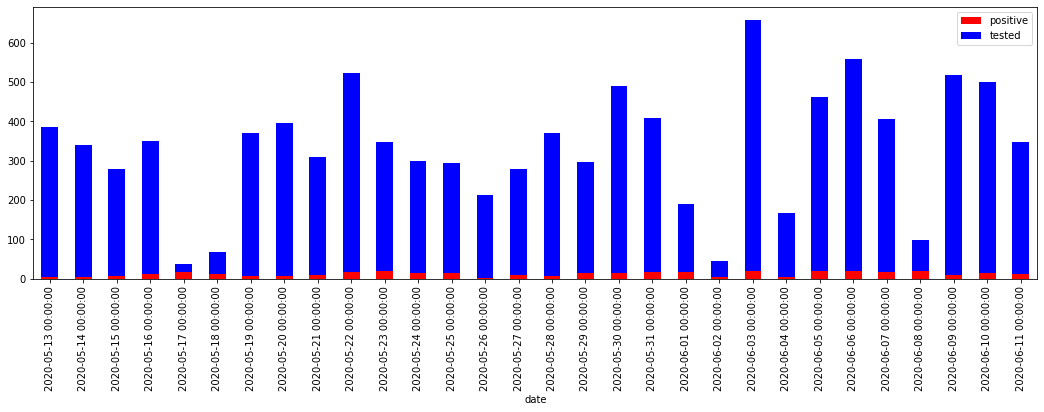

In [84]:
chart= df[['positive','tested']].diff()[-30:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [101]:
(df.positive/df.tested).rolling(window=7).mean()[-7:]

date
2020-06-05    0.036198
2020-06-06    0.036387
2020-06-07    0.036577
2020-06-08    0.036806
2020-06-09    0.036917
2020-06-10    0.037045
2020-06-11    0.037187
dtype: float64

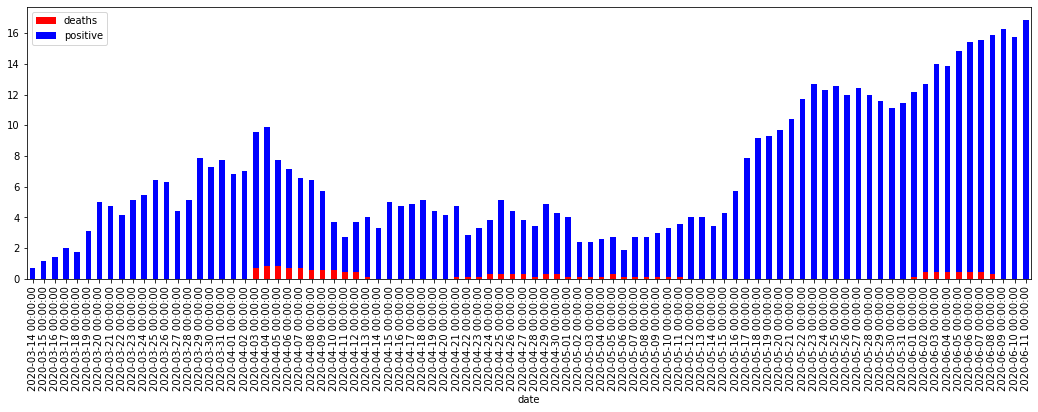

In [85]:
chart= df[['deaths','positive']].diff()\
.rolling(window=7).mean()[-90:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [86]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.25%
Marin Population Tested: 6.69%


In [87]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-06-07    15.142857
2020-06-08    15.571429
2020-06-09    16.285714
2020-06-10    15.714286
2020-06-11    16.857143
Name: positive, dtype: float64

In [88]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(28)[::-1].positive.diff()


date
2020-05-15       NaN
2020-05-16    1857.0
2020-05-17    2046.0
2020-05-18    1591.0
2020-05-19    1365.0
2020-05-20    2262.0
2020-05-21    2140.0
2020-05-22    2247.0
2020-05-23    2187.0
2020-05-24    2079.0
2020-05-25    1848.0
2020-05-26    2175.0
2020-05-27    2247.0
2020-05-28    2717.0
2020-05-29    2189.0
2020-05-30    2992.0
2020-05-31    3705.0
2020-06-01    2423.0
2020-06-02    2304.0
2020-06-03    2377.0
2020-06-04    2120.0
2020-06-05    3094.0
2020-06-06    3115.0
2020-06-07    2796.0
2020-06-08    2507.0
2020-06-09    2170.0
2020-06-10    2702.0
2020-06-11    3090.0
Name: positive, dtype: float64